<a href="https://colab.research.google.com/github/kscale/QuickLearn/blob/master/08using_a_pretrianed_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

using a pretrianed Vit from torchvision.models
- 参考https://www.learnpytorch.io/08_pytorch_paper_replicating/

In [1]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##00.setup

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3297, done.
remote: Counting objects: 100% (277/277), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 3297 (delta 137), reused 230 (delta 110), pack-reused 3020
Receiving objects: 100% (3297/3297), 642.58 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (1867/1867), done.
Checking out files: 100% (221/221), done.


##01.get data

In [37]:
# # Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
#                            destination="pizza_steak_sushi")
# image_path

In [4]:
# 使用20%的数据
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
from helper_functions import walk_through_dir
walk_through_dir(train_dir)

There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi/train/steak'.


In [7]:
# 如何从文件路径中直接获取类别 class_names
import os
file_path = train_dir  #PosixPath('data/pizza_steak_sushi/train')
class_names = os.path.basename(os.path.dirname(file_path)).split('_')
class_names

['pizza', 'steak', 'sushi']

##02.get pretained vit-base

In [8]:
#　１．get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. setup a vit model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# 4. change the classifier head
set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768,out_features=len(class_names)).to(device)


pretrained_vit




Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [9]:
# # Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]
├─Encoder (encoder)                                          [32, 197, 768]
│    └─Dropout (dropout)                                     [32, 197, 768]
│    └─Sequential (layers)                                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_3)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_4)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_5)                   [32, 197, 768]
│    │    └─EncoderBlock (encoder_layer_6)                   [32, 197, 768]
│    │   

##03.set transforms 

In [10]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


##04.dataloader

In [11]:
# setup dataloaders
train_dataloader_pretrained,test_dataloader_pretrained,class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = pretrained_vit_transforms,
    batch_size = 32
)
#train_dataloader_pretrained,test_dataloader_pretrained,class_names

##05.train

In [12]:
# 使用engine.train()训练
from going_modular.going_modular import engine

# create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# train
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                  train_dataloader=train_dataloader_pretrained,
                  test_dataloader=test_dataloader_pretrained,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=10,
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


##06 plot

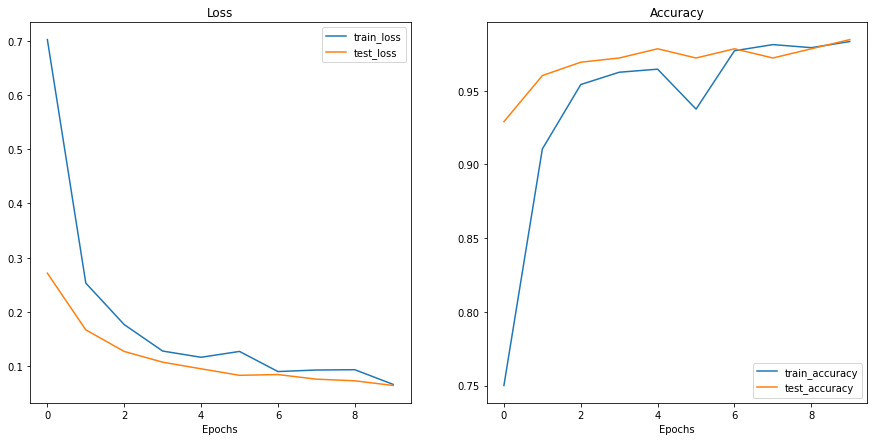

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

##07 save feature extractor ViT model and check file size

In [17]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


### know the model size

In [15]:
from pathlib import Path
# get the model size bytes----> megabytes

pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 

print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")



Pretrained ViT feature extractor model size: 327 MB


##08.predict

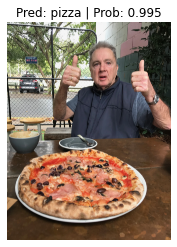

In [18]:
import requests
# Import function to make predictions on images and plot them 
from going_modular.going_modular.predictions import pred_and_plot_image

# setup custom image path
custom_image_path = image_path / "04-pizza-dad.jpeg"

# download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path,"wb") as f:

# When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)